# Task 1: Fine-tune Chemical Language Model

The goal is to fine-tune a pre-trained chemical language model on a regression task using the Lipophilicity dataset. The task involves predicting the lipophilicity value for a given molecule representation (SMILES string). You will learn how to load and tokenize a dataset from HuggingFace, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [ ]:
%%capture
!pip install datasets

In [ ]:
# import dependencies
import torch
from datasets import load_dataset
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
from tqdm.notebook import tqdm
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1.Fine-tune a Chemical Language Model on Lipophilicity


## --- Step 1: Load Dataset ---

The dataset we are going to use is the [Lipophilicity](https://huggingface.co/datasets/scikit-fingerprints/MoleculeNet_Lipophilicity) dataset, part of [MoleculeNet](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a) benchmark.

Lipophilicity, also known as hydrophobicity, is a measure of how readily a substance dissolves in nonpolar solvents (such as oil) compared to polar solvents (such as water).

In [ ]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

In [ ]:
# load the dataset from HuggingFace
dataset = load_dataset(DATASET_PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print(type(dataset))
print(dataset)

<class 'datasets.dataset_dict.DatasetDict'>
DatasetDict({
    train: Dataset({
        features: ['SMILES', 'label'],
        num_rows: 4200
    })
})


In [ ]:
# Explore the dataset
# For example, print the column names and display a few sample rows
dataset_pd = dataset['train'].to_pandas()
dataset_pd.head()

SMILES  label
0            Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14   3.54
1  COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...  -1.18
2             COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl   3.69
3  OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...   3.37
4  Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...   3.10

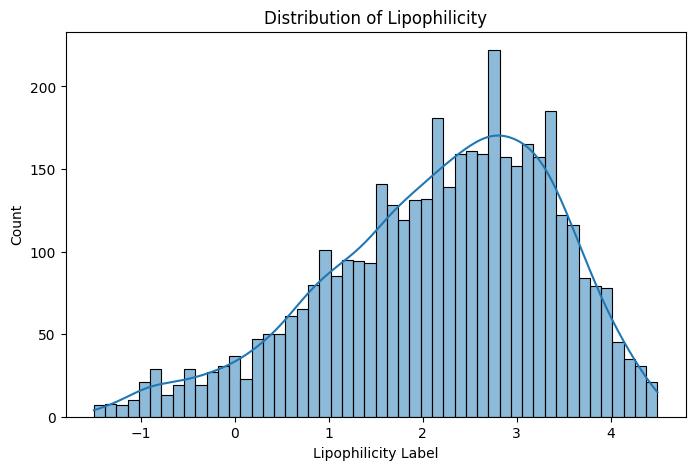

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(dataset_pd['label'], bins=50, kde=True)
plt.xlabel("Lipophilicity Label")
plt.ylabel("Count")
plt.title("Distribution of Lipophilicity")
plt.show()

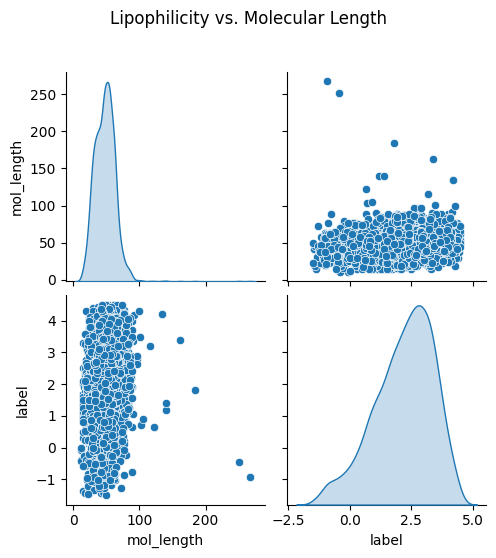

In [ ]:
dataset_pd['mol_length'] = dataset_pd['SMILES'].apply(len)

pairplot = sns.pairplot(dataset_pd[['mol_length', 'label']], diag_kind="kde")
pairplot.fig.suptitle("Lipophilicity vs. Molecular Length", y=1.1)

plt.show()

In [ ]:
# define a PyTorch Dataset class for handling SMILES strings and targets
class SMILESDataset(Dataset):
    def __init__(self, smiles, targets, tokenizer):
        super(SMILESDataset).__init__()
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self,index):
        smiles_element = self.smiles[index]
        target_element = torch.tensor(self.targets[index], dtype = torch.float32)
        smiles_element_tokenized = self.tokenizer(smiles_element,
                                                  padding=True,  truncation=True, max_length=300,
                                                  return_tensors="pt")

        return {
            'input_ids': smiles_element_tokenized['input_ids'].squeeze(0),
            'attention_mask': smiles_element_tokenized['attention_mask'].squeeze(0),
            'target': target_element
        }

## --- Step 2: Split Dataset ---

As there is only one split (train split) in the original dataset, we need to split the data into training and testing sets by ourselves.

In [ ]:
# tokenize the data
# load a pre-trained tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

In [ ]:
# split the data into training and test datasets
df = pd.DataFrame(dataset['train'])
train_smiles, test_smiles, train_targets, test_targets = train_test_split(df['SMILES'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)

In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    mlm_probability=0.15
)

In [ ]:
BATCH_SIZE = 16 # adjust based on memory constraints

In [ ]:
# construct Pytorch data loaders for both train and test datasets
train_data_loader = DataLoader(SMILESDataset(train_smiles, train_targets, tokenizer), batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
test_data_loader = DataLoader(SMILESDataset(test_smiles, test_targets, tokenizer), batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

## --- Step 3: Load Model ---

In [ ]:
# load pre-trained model from HuggingFace
model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True)

In [ ]:
# specify model with a regression head
class MoLFormerWithRegressionHead(nn.Module):
    def __init__(self, model):
        super(MoLFormerWithRegressionHead, self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.regression_head = nn.Linear(model.config.hidden_size, 1)

    def forward(self, inputs, attention_mask):
        output = self.model(inputs, attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        return self.regression_head(pooled_output)

In [ ]:
# initialize the regression model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model = MoLFormerWithRegressionHead(model).to(device)

In [ ]:
regression_model

MoLFormerWithRegressionHead(
  (model): MolformerModel(
    (embeddings): MolformerEmbeddings(
      (word_embeddings): Embedding(2362, 768, padding_idx=2)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): MolformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x MolformerLayer(
          (attention): MolformerAttention(
            (self): MolformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (rotary_embeddings): MolformerRotaryEmbedding()
              (feature_map): MolformerFeatureMap(
                (kernel): ReLU()
              )
            )
            (output): MolformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      

## --- Step 4: Training ---

Epoch 1:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 1 Loss: 1.024325035015742
Model checkpoint saved at epoch 1


Epoch 2:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2 Loss: 0.5635918624344326
Model checkpoint saved at epoch 2


Epoch 3:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 3 Loss: 0.4194734381068321
Model checkpoint saved at epoch 3


Epoch 4:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4 Loss: 0.3349698946944305
Model checkpoint saved at epoch 4


Epoch 5:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 5 Loss: 0.27908566846024424
Model checkpoint saved at epoch 5


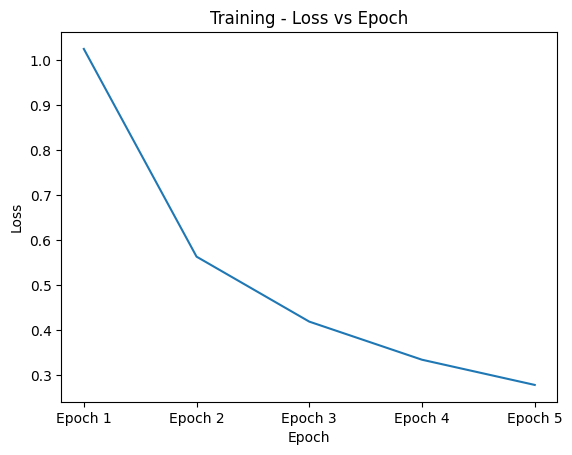

In [ ]:
def train_model(mse_loss, optimizer, epochs, train_data_loader, folder_path, model):
    SAVE_PATH = f"/content/model_checkpoints/{folder_path}"
    os.makedirs(SAVE_PATH, exist_ok=True)
    epochs_lossses = []
    epochs_names = []

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}"):
            input_ids, attention_mask, target = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['target'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask).squeeze()

            loss = mse_loss(outputs, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        epochs_lossses.append(total_loss / len(train_data_loader))
        epochs_names.append(f'Epoch {epoch+1}')
        print(f"Epoch {epoch+1} Loss: {total_loss / len(train_data_loader)}")

        # Save model checkpoint for each epoch
        torch.save(model.state_dict(), os.path.join(SAVE_PATH, f"model_epoch_{epoch+1}.pth"))
        print(f"Model checkpoint saved at epoch {epoch+1}")

    plt.plot(epochs_names, epochs_lossses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training - Loss vs Epoch')
    plt.show()

mse_loss = nn.MSELoss()
optimizer = torch.optim.AdamW(regression_model.parameters(), lr=1e-4)
epochs = 5

train_model(mse_loss, optimizer, epochs, train_data_loader, "training", regression_model)

## --- Step 5: Evaluation ---

In [ ]:
def evaluate_model(mse_loss, test_data_loader, model):
  model.eval()
  total_loss = 0
  targets_values = []
  predictions_values = []

  with torch.no_grad():
    for batch in tqdm(test_data_loader, desc=f"Evaluation"):
      input_ids, attention_mask, target = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['target'].to(device)
      outputs = model(input_ids, attention_mask).squeeze()
      loss = mse_loss(outputs, target)
      total_loss += loss.item()
      predictions_values.extend(outputs.cpu().numpy())
      targets_values.extend(target.cpu().numpy())

  r2 = r2_score(targets_values, predictions_values)

  return total_loss / len(test_data_loader), r2

evaluation_loss, r2 = evaluate_model(mse_loss, test_data_loader, regression_model)
print(f"Evaluation Loss: {evaluation_loss} - R2 score = {r2}")

Evaluation:   0%|          | 0/53 [00:00<?, ?it/s]

Evaluation Loss: 0.5126189786308216 - R2 score = 0.6544096868681876


# 2.Add Unsupervised Finetuning
In this step, you will perform unsupervised fine-tuning on the training dataset. This means the model will leverage only the SMILES strings without any corresponding labels to adapt its understanding of the data distribution. By familiarizing the model with the patterns and structure of the SMILES strings, you can potentially enhance its performance on downstream supervised tasks.

For this fine-tuning, you will use the Masked Language Modeling (MLM) objective, where the model learns to predict randomly masked tokens within the input sequence. Remember to save the fine-tuned model for later use.


Epoch 1:   0%|          | 0/210 [00:00<?, ?it/s]

Model checkpoint saved at epoch 1


Epoch 2:   0%|          | 0/210 [00:00<?, ?it/s]

Model checkpoint saved at epoch 2


Epoch 3:   0%|          | 0/210 [00:00<?, ?it/s]

Model checkpoint saved at epoch 3


Epoch 4:   0%|          | 0/210 [00:00<?, ?it/s]

Model checkpoint saved at epoch 4


Epoch 5:   0%|          | 0/210 [00:00<?, ?it/s]

Model checkpoint saved at epoch 5


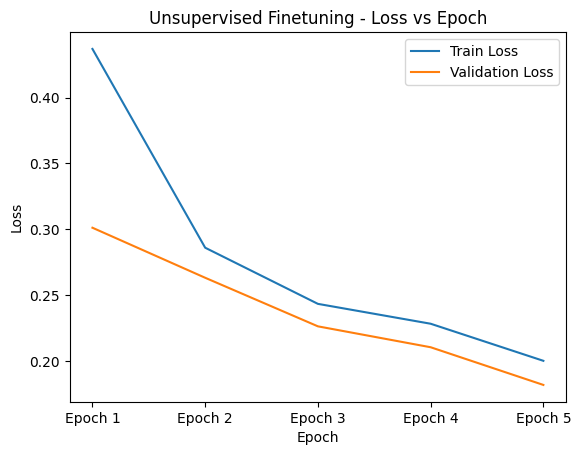

In [ ]:
def unsupervised_finetune(MODEL_NAME, epochs, tokenizer, train_data_loader, test_data_loader):
  mlm_model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME,  deterministic_eval=True, trust_remote_code=True).to(device)


  optimizer = torch.optim.AdamW(mlm_model.parameters(), lr=1e-5)
  SAVE_PATH = "/content/model_checkpoints/unsupervised"
  os.makedirs(SAVE_PATH, exist_ok=True)

  data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=True,  # Enable MLM
        mlm_probability=0.15  # 15% of tokens will be masked
    )

  epochs_names = []
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    mlm_model.train()
    total_loss = 0
    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}"):
      input_ids, attention_mask, target = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['target'].to(device)
      batch_masked = data_collator(
          [{"input_ids": ids, "attention_mask": mask} for ids, mask in zip(input_ids, attention_mask)]
      )

      input_ids_masked = batch_masked["input_ids"].to(device)
      labels = batch_masked["labels"].to(device)

      optimizer.zero_grad()
      outputs = mlm_model(input_ids=input_ids_masked, attention_mask=attention_mask, labels=labels)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

    train_losses.append(total_loss / len(train_data_loader))

    mlm_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_data_loader:
            input_ids, attention_mask, target = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['target'].to(device)

            batch_masked = data_collator(
                [{"input_ids": ids, "attention_mask": mask} for ids, mask in zip(input_ids, attention_mask)]
            )

            input_ids_masked = batch_masked["input_ids"].to(device)
            labels = batch_masked["labels"].to(device)

            optimizer.zero_grad()
            outputs = mlm_model(input_ids=input_ids_masked, attention_mask=attention_mask, labels=labels)
            total_val_loss += outputs.loss

    avg_val_loss = total_val_loss / len(test_data_loader)
    val_losses.append(avg_val_loss)

    epochs_names.append(f'Epoch {epoch+1}')
    torch.save(mlm_model.state_dict(), os.path.join(SAVE_PATH, f"model_epoch_mlm_{epoch+1}.pth"))
    print(f"Model checkpoint saved at epoch {epoch+1}")

  train_losses = np.array(train_losses)
  val_losses = torch.tensor(val_losses).cpu().numpy()

  plt.plot(epochs_names, train_losses, label="Train Loss")
  plt.plot(epochs_names, val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.title("Unsupervised Finetuning - Loss vs Epoch")
  plt.show()

  return mlm_model

epochs = 5
mlm_model_fine_tuned = unsupervised_finetune(MODEL_NAME, epochs, tokenizer, train_data_loader, test_data_loader)

# 3.Fine-Tune for Comparison
After performing unsupervised fine-tuning on the training data, we now fine-tune the model on the regression task with the regression head. By comparing the performance of the model before and after unsupervised fine-tuning, you can evaluate how the unsupervised fine-tuning impacts the model's performance on our target task.


In [ ]:
class RegressionModel(nn.Module):
    def __init__(self, mlm_model):
        super(RegressionModel, self).__init__()
        self.base_model = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.2)
        self.regression_head = nn.Linear(self.base_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        return self.regression_head(pooled_output)

regression_model = RegressionModel(mlm_model_fine_tuned).to(device)

The repository for ibm/MoLFormer-XL-both-10pct contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/ibm/MoLFormer-XL-both-10pct.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Epoch 1:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 1: Train Loss = 1.3583, Validation Loss = 0.9396


Epoch 2:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.7483, Validation Loss = 0.7512


Epoch 3:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.5340, Validation Loss = 0.6153


Epoch 4:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.4147, Validation Loss = 0.5531


Epoch 5:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.3448, Validation Loss = 0.4959


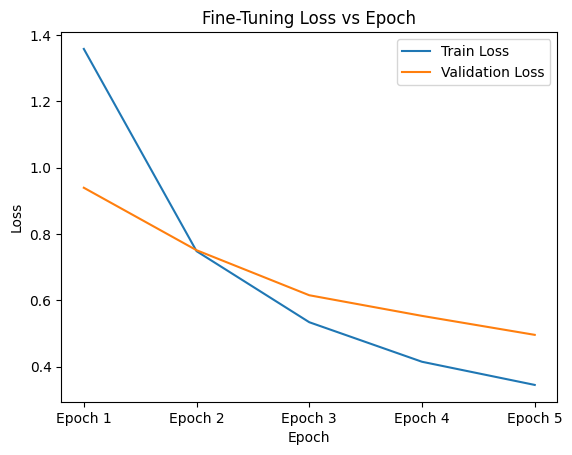

In [ ]:
def fine_tune_regression(mse_loss, model, train_loader, val_loader, num_epochs):
    """Fine-tune the model for regression using MSE loss."""

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    SAVE_PATH = "/content/model_checkpoints/regression"
    os.makedirs(SAVE_PATH, exist_ok=True)

    train_losses = []
    val_losses = []
    epochs_names = []

    for epoch in range(num_epochs):
        total_train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids, attention_mask, target = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['target'].to(device)

            optimizer.zero_grad()
            predictions = model(input_ids, attention_mask).squeeze()
            loss = mse_loss(predictions, target)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, target = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['target'].to(device)

                predictions = model(input_ids, attention_mask).squeeze()
                loss = mse_loss(predictions, target)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        epochs_names.append(f"Epoch {epoch+1}")
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Validation Loss = {avg_val_loss:.4f}")
        torch.save(model.state_dict(), os.path.join(SAVE_PATH, f"model_epoch_regression_finetune_{epoch+1}.pth"))

    plt.plot(epochs_names, train_losses, label="Train Loss")
    plt.plot(epochs_names, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Fine-Tuning Loss vs Epoch")
    plt.show()

    return model

num_epochs = 5
mse_loss = torch.nn.MSELoss()
regression_model = fine_tune_regression(mse_loss, regression_model, train_data_loader, test_data_loader, num_epochs)

### Libraries that need to be imported

- importing os, numpy, matplotlib, sklearn, seaborn, pandas, random module

### External links used
- Unsupervised Documentation: https://pytorch.org/TensorRT/_notebooks/Hugging-Face-BERT.html
- Difference between Adam and AdamW: https://yassin01.medium.com/adam-vs-adamw-understanding-weight-decay-and-its-impact-on-model-performance-b7414f0af8a1
- Train & Evaluation Flow: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html